<a href="https://colab.research.google.com/github/andres-tovar-purdue/materials/blob/main/HGP_BO_2D_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

White, G.M., A.P. Siegel, and A. Tovar. Optimizing Thermoplastic Starch Film with Heteroscedastic Gaussian Processes in a Bayesian Experimental Design Framework. *Materials*, Special Issue: Modelling, Simulation and Optimisation of Non-typical and Innovative Materials, 2024.

**Section 3.5: Numerical Example.** Bayesian optimization of a two-dimensional noisy function using a heteroscedastic Gaussian process regression model.

In [1]:
!pip install gpflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.7 MB/s eta 0:00:00


In [2]:
import tensorflow
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import pandas as pd

In [3]:
# Vanilla GP model
def train_gp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_gp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, variables=model.trainable_variables)
    return model

def train_pgp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=0.3)
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.Matern32())
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_pgp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

In [4]:
# Expected Improvement function for minimization
from scipy.stats import norm
def expected_improvement(y_best, f_mean, f_std):
    delta = y_best - f_mean
    with np.errstate(divide='ignore'):
        Z = delta / f_std
        ei = delta * norm.cdf(Z) + f_std * norm.pdf(Z)
        ei[f_std == 0.0] = 0.0
    return ei

In [5]:
# Three hump camel function
def calculate_y2_true(x1, x2):
  return 2 * x1**2 - 1.05 * x1**4 + x1**6 / 6 + x1 * x2 + x2**2

# Variance function
def noise_var2_fun(x1, x2):
  variance = (x1 + 1)**2 + (x2 + 1)**2
  return variance/50

# Noisy three hump camel function
def calculate_y2_noisy(x1, x2):
    true_value = calculate_y2_true(x1, x2)
    noise_variance = noise_var2_fun(x1, x2)
    noise_value = np.random.normal(0, np.sqrt(noise_variance), x1.shape)
    return true_value + noise_value

In [6]:
def plot_contour (X1, X2, Z, title="", color_map='viridis',dpi=300):
  # Plotting
  fontsize = 5/0.67
  linewidth = 1/0.67
  mark_size = 3/0.67

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  c1 = ax.contourf(X1, X2, Z, cmap=color_map, levels=15)
  c2 = ax.contour(X1, X2, Z, colors='black', linewidths=linewidth/2, levels=15)

  ax.set_aspect('equal')
  ax.set_title(title)
  ax.clabel(c2, inline=1, fmt='%1.2f', fontsize=fontsize)
  ax.tick_params(axis='both', which='major', labelsize=fontsize)
  ax.set_xlabel('$x_1$', fontsize=fontsize)
  ax.set_ylabel('$x_2$', fontsize=fontsize)
  return fig, ax

(<Figure size 650x550 with 1 Axes>, <Axes: xlabel='$x_1$', ylabel='$x_2$'>)

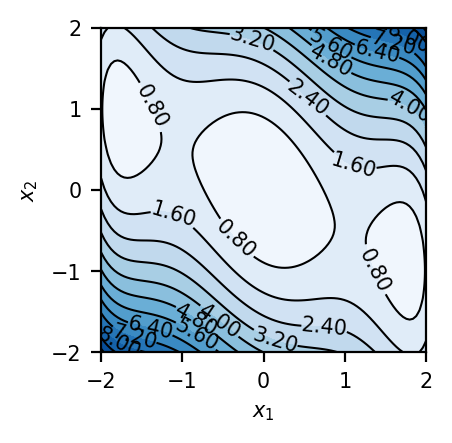

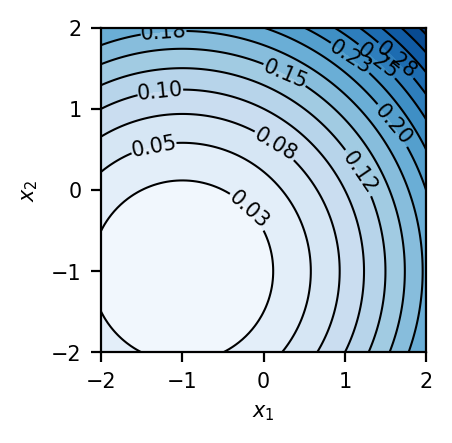

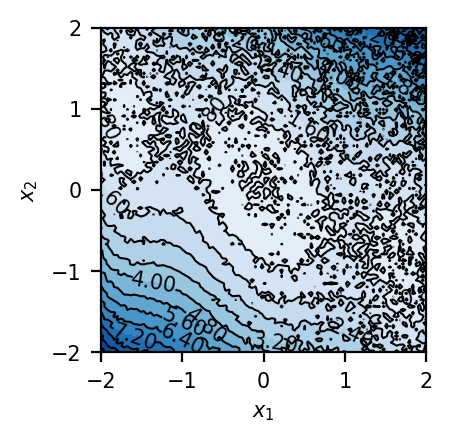

In [7]:
# For the exploration regions
x1_abs_min = -2
x1_abs_max = 2
x2_abs_min = -2
x2_abs_max = 2

# Round
x1_abs_max = np.round(2*x1_abs_max)/2
x2_abs_max = np.round(2*x2_abs_max)/2

# Plots
x1 = np.linspace(x1_abs_min, x1_abs_max, 100)
x2 = np.linspace(x1_abs_min, x1_abs_max, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
f_grid = calculate_y2_true(x1_grid, x2_grid)
v_grid = noise_var2_fun(x1_grid, x2_grid)
fv_grid = calculate_y2_noisy(x1_grid, x2_grid)
# plot_contour (x1_grid, x2_grid, f_grid, title="", color_map='coolwarm')
plot_contour (x1_grid, x2_grid, f_grid, title="", color_map='Blues', dpi=200)
plot_contour (x1_grid, x2_grid, v_grid, title="", color_map='Blues', dpi=200)
plot_contour (x1_grid, x2_grid, fv_grid, title="", color_map='Blues', dpi=200)

# GPR of the noise variance

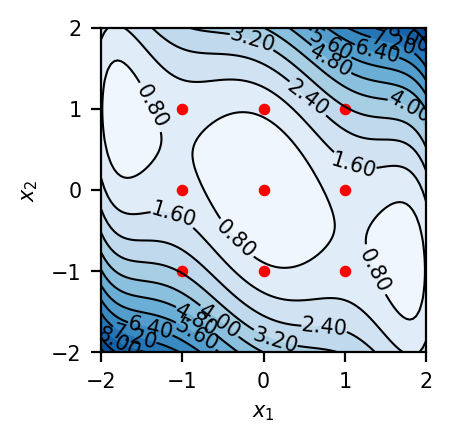

In [8]:
# Sampling plan
x1doe = np.linspace(-1, 1, 3)
x2doe = np.linspace(-1, 1, 3)
x1doe_grid, x2doe_grid = np.meshgrid(x1doe, x2doe)

# Plot points
fig, ax = plot_contour (x1_grid, x2_grid, f_grid, title="", color_map='Blues', dpi=200)
ax.scatter(x1doe_grid, x2doe_grid, color='r', s=10)
plt.show()

# Bayesian Optimization

In [9]:
# Observations of the noiy function (in Step 2)
def fun_2d_eval(x1_grid, x2_grid, num_reps=5):
  x1_reps, x2_reps, y_reps = [], [], []
  for pos in range(len(x1_grid)):
    for _ in range(num_reps):
      y = calculate_y2_noisy(x1_grid[pos], x2_grid[pos])
      x1_reps.append(x1_grid[pos])
      x2_reps.append(x2_grid[pos])
      y_reps.append(y)
  return np.array(x1_reps), np.array(x2_reps), np.array(y_reps)

# Test
x1_reps, x2_reps, y_reps = fun_2d_eval(x1doe_grid.flatten(), x2doe_grid.flatten(), num_reps=5)
df = pd.DataFrame({'x1': x1_reps, 'x2': x2_reps, 'y': y_reps})
df.to_csv('input.csv', index=False)

In [10]:
def process_reps_csv(x_reps, y_reps, input_file, output_file):
  df = pd.DataFrame({'x': x_reps, 'y': y_reps})
  # Save input file
  df.to_csv(input_file, index=False)

  dfxyz = df.groupby('x')['y'].agg(['mean', 'var', 'count'])
  dfxyz = dfxyz.reset_index() # Reset the index to make 'x' a column again
  # Save output file
  dfxyz.to_csv(output_file, index=False)

  xmean = dfxyz['x'].to_numpy()
  ymean = dfxyz['mean'].to_numpy() # Access 'mean' column instead of 'y_mean'
  yvar = dfxyz['var'].to_numpy()  # Access 'var' column instead of 'y_var'

  return xmean, ymean, yvar

In [11]:
def process_reps(x_reps, y_reps):
  df = pd.DataFrame({'x': x_reps, 'y': y_reps})
  dfxyz = df.groupby('x')['y'].agg(['mean', 'var', 'count'])
  dfxyz = dfxyz.reset_index() # Reset the index to make 'x' a column again
  xmean = dfxyz['x'].to_numpy()
  ymean = dfxyz['mean'].to_numpy() # Access 'mean' column instead of 'y_mean'
  yvar = dfxyz['var'].to_numpy()  # Access 'var' column instead of 'y_var'
  return xmean, ymean, yvar

In [12]:
def process_reps2(x1_reps, x2_reps, y_reps):
  df = pd.DataFrame({'x1': x1_reps, 'x2': x2_reps, 'y': y_reps})
  dfxyz = df.groupby(['x1','x2'])['y'].agg(['mean', 'var', 'count'])
  dfxyz = dfxyz.reset_index() # Reset the index to make 'x' a column again
  x1mean = dfxyz['x1'].to_numpy()
  x2mean = dfxyz['x2'].to_numpy()
  ymean = dfxyz['mean'].to_numpy() # Access 'mean' column instead of 'y_mean'
  yvar = dfxyz['var'].to_numpy()  # Access 'var' column instead of 'y_var'
  return x1mean, x2mean, ymean, yvar


In [13]:
# Exploration region - rounded
def x_grid_fun(x1vec, x2vec, scale=1):

  # Identify min and max
  x1min = np.min(x1vec)
  x1max = np.max(x1vec)
  x2min = np.min(x2vec)
  x2max = np.max(x2vec)

  x1_length = x1max - x1min
  x2_length = x2max - x2min
  # print(x1_length, x2_length)

  # Limits
  x1_LB = x1min - 0.5*x1_length*scale
  x1_UB = x1max + 0.5*x1_length*scale
  x2_LB = x2min - 0.5*x2_length*scale
  x2_UB = x2max + 0.5*x2_length*scale

  # Correction of limits
  x1_LB = max(x1_abs_min, x1_LB)
  x1_UB = min(x1_abs_max, x1_UB)
  x2_LB = max(x2_abs_min, x2_LB)
  x2_UB = min(x2_abs_max, x2_UB)

  # Round
  x1_LB = np.round(x1_LB, 2)
  x1_UB = np.round(x1_UB, 2)
  x2_LB = np.round(x2_LB, 2)
  x2_UB = np.round(x2_UB, 2)

  print('Exploration region limits:')
  print(x1_LB, x1_UB, x2_LB, x2_UB)

  # Grid
  x1_lin = np.linspace(x1_LB, x1_UB, 100)
  x2_lin = np.linspace(x2_LB, x2_UB, 100)
  x1_grid, x2_grid = np.meshgrid(x1_lin, x2_lin)
  X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

  return X_grid, x1_grid, x2_grid

In [14]:
# Add corner points
def get_four_cornes(X):
  x1_min = np.min(X[:, 0])
  x2_min = np.min(X[:, 1])
  x1_max = np.max(X[:, 0])
  x2_max = np.max(X[:, 1])
  X_new = np.array([[x1_min, x2_min], [x1_min, x2_max], [x1_max, x2_min], [x1_max, x2_max]])
  return X_new

# Remove duplicates
def remove_duplicates(X_doe, X_new_doe):
  # If the row of X_new_doe is in X_doe, then remove that row from X_new_doe
  rows_to_remove = []
  for i in range(X_new_doe.shape[0]):
    if any(np.allclose(X_new_doe[i], row) for row in X_doe):
      rows_to_remove.append(i)
  X_new_doe = np.delete(X_new_doe, rows_to_remove, axis=0)
  x1_new = X_new_doe[:, 0]
  x2_new = X_new_doe[:, 1]
  return X_new_doe, x1_new, x2_new


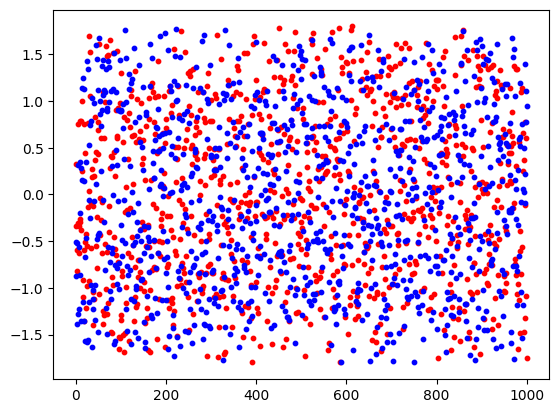

In [15]:
# Check
x1random = []
x2random = []
num = 1000
for _ in range(num):
  # Step 1: Random sampling plan (5 points)
  delta1 = max(0.1, 4*np.random.rand()/10) # distance in x1
  delta2 = max(0.1, 4*np.random.rand()/10) # distance in x2
  x1center = 4*(1-delta1)*np.random.rand()-2*(1-delta1)
  x2center = 4*(1-delta2)*np.random.rand()-2*(1-delta2)
  # x1center = 4*np.random.rand()-2
  # x2center = 4*np.random.rand()-2
  x1random.append(x1center)
  x2random.append(x2center)

plt.scatter(np.linspace(0,num,num), x1random, color='r', s=10)
plt.scatter(np.linspace(0,num,num), x2random, color='b', s=10)
plt.show()


In [16]:
# Number of iterations
num_outer_iter = 10 # 10
num_inner_iter = 31 # 31

# filename = 'results.csv'
df_res = pd.DataFrame({'iter': [], 'x1_best': [], 'x2_best': [], 'y_best': [], 'max_ei': []})
df_res.to_csv('results.csv', index=False)

# filename2 = 'input.csv'
df_inp = pd.DataFrame({'x1_reps': [], 'x2_reps': [], 'y_reps': []})
df_inp.to_csv('input.csv', index=False)

# Loop
for outer_iter in range(num_outer_iter):
  print('outer_iter=', outer_iter)

  # Step 1: Random sampling plan (5 points)
  delta1 = max(0.1, 4*np.random.rand()/10) # distance in x1
  delta2 = max(0.1, 4*np.random.rand()/10) # distance in x2
  x1center = 4*(1-delta1)*np.random.rand()-2*(1-delta1)
  x2center = 4*(1-delta2)*np.random.rand()-2*(1-delta2)
  x1_doe = np.array([x1center-delta1, x1center, x1center+delta1])
  x2_doe = np.array([x2center-delta2, x2center, x2center+delta2])
  x1_mesh, x2_mesh = np.meshgrid(x1_doe, x2_doe)
  x1_mesh = np.round(x1_mesh, 2)
  x2_mesh = np.round(x2_mesh, 2)

  # Step 2: Observations of the noisy function
  x1_reps, x2_reps, y_reps = fun_2d_eval(x1_mesh.flatten(), x2_mesh.flatten(), num_reps=5)
  df_inp_new = pd.DataFrame({'x1_reps': x1_reps, 'x2_reps': x2_reps, 'y_reps': y_reps})
  df_inp = pd.concat([df_inp, df_inp_new], ignore_index=True)

  # Loop
  for iter in range(num_inner_iter):

    # Step 3: Gather data
    x1mean, x2mean, ymean, yvar = process_reps2(x1_reps, x2_reps, y_reps)

    # Step 4: GP of ymean
    X = np.vstack((x1mean, x2mean)).T
    ymean = ymean.reshape(-1, 1)
    yvar = yvar.reshape(-1, 1)
    ymean_model = train_gp2_model(X, ymean, k='m32', lambda_=1e-3)

    X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T
    ymean_mean, ymean_var = ymean_model.predict_f(X_grid)
    ymean_mean = np.array(ymean_mean).flatten()
    ymean_var = np.array(ymean_var).flatten()

    # Step 5: GP of yvar models
    yvar_model = train_gp_model(X, yvar, k='m32')
    yvar_mean, yvar_var = yvar_model.predict_f(X_grid)
    yvar_mean = np.array(yvar_mean).flatten()
    yvar_var = np.array(yvar_var).flatten()

    # Step 6: Obtain the f(x_best)
    min_index = np.argmin(ymean)
    x1_best = x1mean[min_index]
    x2_best = x2mean[min_index]
    y_best = ymean[min_index]
    print(x1_best, x2_best, y_best)

    # Step 6-7: Exploration region
    X_region, x1_region, x2_region = x_grid_fun(x1_reps, x2_reps, scale=1)
    ymean_mean_region, ymean_var_region = ymean_model.predict_f(X_region)
    yvar_mean_region, yvar_var_region = yvar_model.predict_f(X_region)

    ymean_mean_region = np.array(ymean_mean_region).flatten()
    ymean_var_region = np.array(ymean_var_region).flatten()
    yvar_mean_region = np.array(yvar_mean_region).flatten()
    yvar_var_region = np.array(yvar_var_region).flatten()

    # Step 7: Lower confidence bound
    def get_lcb(kappa=2.0):
      lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
      min_lcb_index = np.argmin(lcb_grid)
      x1_new_lcb = x1_grid.flatten()[min_lcb_index]
      x2_new_lcb = x2_grid.flatten()[min_lcb_index]
      x1_new_lcb = np.round(x1_new_lcb, 2) # Rounded
      x2_new_lcb = np.round(x2_new_lcb, 2) # Rounded
      return  x1_new_lcb, x2_new_lcb

    # Get LCB x_new point
    kappa = 1.0
    x1_new_lcb, x2_new_lcb = get_lcb(kappa=kappa)

    # Step 8: Expected improvement
    y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
    ei_grid = expected_improvement(y_best, ymean_mean_region, y_std_hgp)
    max_ei_index = np.argmax(ei_grid)
    x1_new_ei = x1_grid.flatten()[max_ei_index]
    x2_new_ei = x2_grid.flatten()[max_ei_index]
    x1_new_ei = np.round(x1_new_ei, 2) # Rounded
    x2_new_ei = np.round(x2_new_ei, 2) # Rounded

    # Step 9: Increase kappa until the two new points are different
    while (x1_new_lcb == x1_new_ei and x2_new_lcb == x2_new_ei) and kappa < 2**12:
      # Adjust kappa to make them different
      kappa = 2**kappa
      kappa += 1
      # print('kappa=', kappa)
      x1_new_lcb, x2_new_lcb = get_lcb(kappa=kappa)

    # Step 9-10: Add corners
    x1_new = np.concatenate((np.array([x1_new_lcb]), np.array([x1_new_ei])))
    x2_new = np.concatenate((np.array([x2_new_lcb]), np.array([x2_new_ei])))

    # Add corner points and clean
    X_new = np.vstack((x1_new, x2_new)).T
    X_four_corners = get_four_cornes(X_region)
    X_new_plus = np.vstack([X_new, X_four_corners])
    X_new = np.unique(X_new_plus, axis=0)
    X_new, x1_new, x2_new = remove_duplicates(X, X_new)

    # Step 10: Save results in a CSV file
    max_ei= np.max(ei_grid)
    print('iter=', outer_iter, iter)
    df_res_new = pd.DataFrame({'iter': [iter], 'x1_best': [x1_best], 'x2_best': [x2_best], 'y_best': [y_best[0]], 'max_ei': [max_ei]})
    df_res = pd.concat([df_res, df_res_new], ignore_index=True)

    # Step 11: Check for convergence
    if max_ei <= 0.1:
      print('Convergence')

    # Step 12: Observations of the new points
    x1_new_reps, x2_new_reps, y_new_reps = fun_2d_eval(x1_new, x2_new, num_reps=5)

    # Add the new points
    x1_reps = np.concatenate((x1_reps, x1_new_reps))
    x2_reps = np.concatenate((x2_reps, x2_new_reps))
    y_reps = np.concatenate((y_reps, y_new_reps))

  # Step 13: Save results in a CSV file
  print('x1_best = ', x1_best)
  print('x2_best = ', x2_best)
  print('y_best = ', y_best)
  print('max_ei = ', max_ei)

print('Saving files...')
df_inp.to_csv('input.csv', index=False)
df_res.to_csv('results.csv', index=False)
print('Finished with no issues')

outer_iter= 0
1.39 0.71 [2.2102898]
Exploration region limits:
0.79 1.99 0.61 1.01
iter= 0 0
0.79 0.61 [1.7267252]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 1
0.79 0.61 [1.7267252]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 2
0.79 -0.67 [0.71643608]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 3
0.79 -0.67 [0.71643608]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 4
-0.38 -0.18 [0.33626545]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 5
-0.38 -0.18 [0.33626545]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 6
-0.38 -0.18 [0.33626545]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 7
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 8
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 9
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 10
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 11
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 12
0.22 

<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 18


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 19


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 20


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


iter= 0 21
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


iter= 0 22
0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 23


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 24


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 25


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 26


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 27


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 28


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 29


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.22 -0.3 [-0.00127233]
Exploration region limits:
-2 2.0 -2 2.0
iter= 0 30
x1_best =  0.22
x2_best =  -0.3
y_best =  [-0.00127233]
max_ei =  nan
outer_iter= 1


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


-0.81 -1.17 [3.21466803]
Exploration region limits:
-1.69 -0.52 -1.47 -1.07
iter= 1 0
2.0 -2.0 [1.86156079]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 1
-2.0 1.56 [1.42767432]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 2
0.55 -0.67 [0.68740678]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 3
-0.67 0.34 [0.41349336]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 4


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


-0.59 0.22 [0.40522972]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 5
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 6
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 7
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 8
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 9
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 10
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 11
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 12
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 13


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 14
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 15
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 16
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 17
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 18
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 19
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 20
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 21
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 22
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 23
Convergence
-0.02 0.22 [-0.06656449]
Exploration region limits:
-2 2.0 -2 2.0
iter= 1 24
Convergence
-0.02 0.22 [-0.066564

<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 9


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 10


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 11


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 12


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 13


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 14


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 15


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 16


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 17


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 18


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 19


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 20


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 21


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 22


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 23


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 24


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 25


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 26


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 27


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 28


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 29


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


0.3 -0.3 [0.08387818]
Exploration region limits:
-2 2.0 -2 2.0
iter= 6 30
x1_best =  0.3
x2_best =  -0.3
y_best =  [0.08387818]
max_ei =  nan
outer_iter= 7


<ipython-input-16-aea61b4d1a90>:75: RuntimeWarning: invalid value encountered in sqrt
  lcb_grid = ymean_mean_region - kappa*np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)
<ipython-input-16-aea61b4d1a90>:88: RuntimeWarning: invalid value encountered in sqrt
  y_std_hgp = np.sqrt(ymean_var_region + yvar_mean_region + yvar_var_region)


1.43 0.24 [1.42590632]
Exploration region limits:
1.05 1.81 -0.03 1.04
iter= 7 0
1.05 -0.03 [0.95820637]
Exploration region limits:
0.58 2.0 -2 2.0
iter= 7 1
1.05 -0.03 [0.95820637]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 2
1.05 -0.03 [0.95820637]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 3
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 4
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 5
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 6
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 7
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 8
-0.46 0.34 [0.16326948]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 9
0.18 -0.1 [-0.02043146]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 10
0.18 -0.1 [-0.02043146]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 11
0.18 -0.1 [-0.02043146]
Exploration region limits:
-2 2.0 -2 2.0
iter= 7 12
0.1 0.1 [-0.05

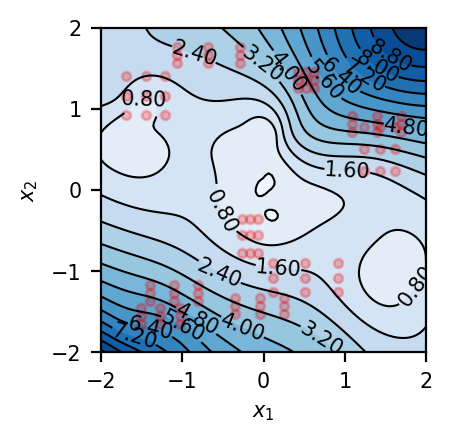

In [17]:
X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T
y_grid, _ = ymean_model.predict_f(X_grid)
y_grid = np.array(y_grid)
plot_contour(x1_grid, x2_grid, y_grid.reshape(x1_grid.shape), title="", color_map='Blues', dpi=200)

df = pd.read_csv('results.csv')
df = pd.DataFrame({'x1_best': df['x1_best'], 'x2_best': df['x2_best']})
# points_and_lines_plot(iter=df['iter'], y_val=df['max_ei'], y_low=0.7, y_high=0.7, y_name='max EI(x)', dpi=200)

df = pd.read_csv('input.csv')
df = pd.DataFrame({'x1_reps': df['x1_reps'], 'x2_reps': df['x2_reps']})
x1_reps = np.array(df['x1_reps'])
x2_reps = np.array(df['x2_reps'])
plt.scatter(x1_reps, x2_reps, color='r', s=10, alpha=0.05)
# plt.plot(x1_reps, x2_reps, color='r', alpha=0.2)

plt.show()

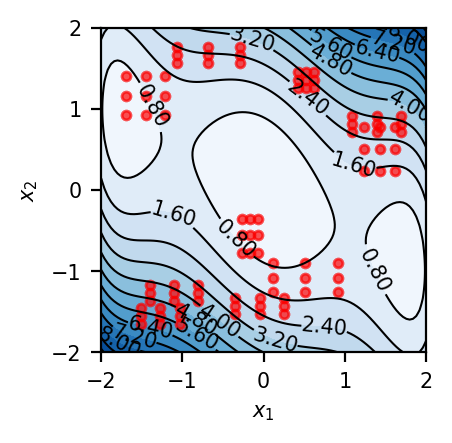

In [21]:
# Plot points
fig, ax = plot_contour(x1_grid, x2_grid, f_grid, title="", color_map='Blues', dpi=200)
ax.scatter(x1_reps, x2_reps, color='r', s=10, alpha=0.2)
plt.show()

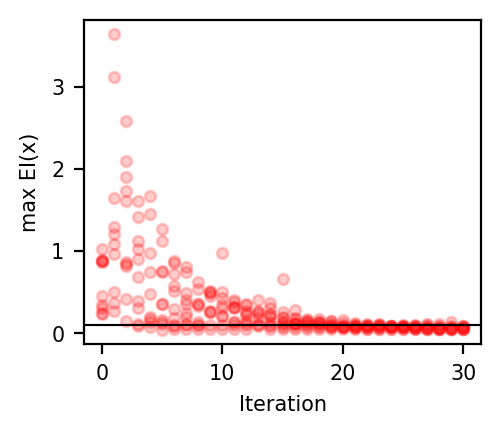

In [22]:
def points_and_lines_plot(iter, y_val, y_low, y_high, y_name='Values',dpi=300):
  # Plotting
  fontsize = 5/0.67
  linewidth = 1/0.67
  mark_size = 10/0.67

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  # ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
  ax.axhline(y=y_low, color='k', linestyle='-', linewidth=linewidth/2)
  ax.axhline(y=y_high, color='k', linestyle='-', linewidth=linewidth/2)
  ax.scatter(iter, y_val, color='r', s=mark_size, label='Observed Points', alpha=0.2)

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y_name, fontsize=fontsize)

  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# Plot
df = pd.read_csv('results.csv')
df = pd.DataFrame({'iter': df['iter'], 'max_ei': df['max_ei']})
points_and_lines_plot(iter=df['iter'], y_val=df['max_ei'], y_low=0.1, y_high=0.1, y_name='max EI(x)', dpi=200)

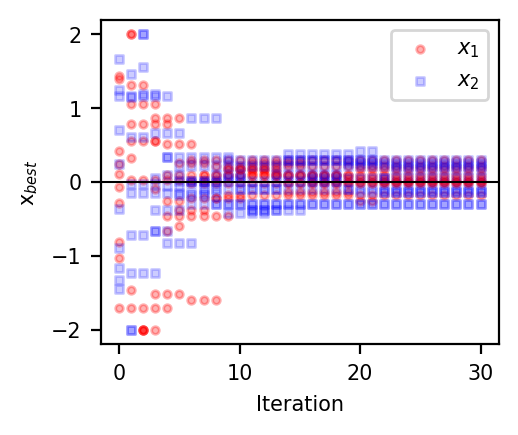

In [23]:
def points2_plot(iter, y1_val, y2_val, y_ref, y_name='Values', dpi=300):
  # Plotting
  fontsize = 5/0.67
  linewidth = 1/0.67
  mark_size = 10/0.67/2

  # Plot preparation
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=dpi)
  fig.tight_layout(pad=3.0)

  # ax.fill_between(iter, y_low, y_high, color='silver', alpha=0.5)
  ax.axhline(y=y_ref, color='k', linestyle='-', linewidth=linewidth/2)
  ax.scatter(iter, y1_val, color='r', marker='o', s=mark_size, label='$x_1$', alpha=0.3)
  ax.scatter(iter, y2_val, color='b', marker='s', s=mark_size, label='$x_2$', alpha=0.2)

  # ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("Iteration", fontsize=fontsize)
  ax.set_ylabel(y_name, fontsize=fontsize)

  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
  ax.legend(fontsize=fontsize)

# Plot
df = pd.read_csv('results.csv')
df = pd.DataFrame({'iter': df['iter'], 'x1_best': df['x1_best'], 'x2_best': df['x2_best']})
# iter_plot(iter=df['iter'], y_val=df['x_best'], y_low=lower_bound, y_high=upper_bound, y_name='x_best')
points2_plot(iter=df['iter'], y1_val=df['x1_best'], y2_val=df['x2_best'], y_ref=0, y_name='x$_{best}$', dpi=200)